# 📓 PBMC 3k — Clustering and Marker Gene Analysis
## Author: Sofiia Eremchuk
## Date: 2025-11-02

Results explanation:

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the PBMC 3k dataset
adata = sc.datasets.pbmc3k()
adata


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

[]

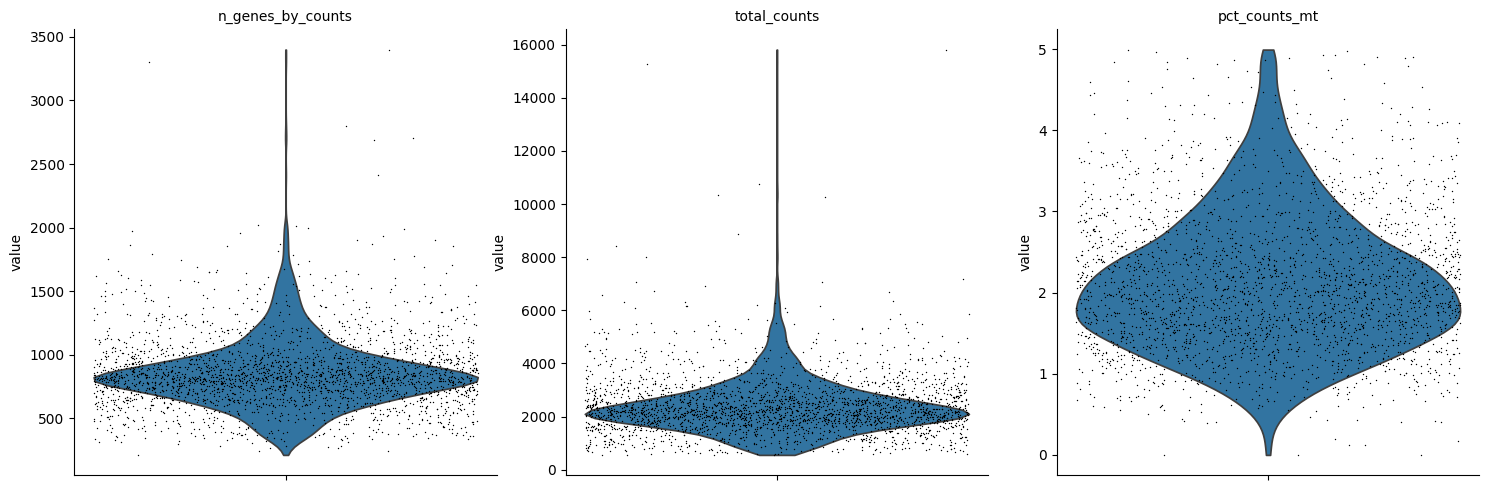

In [ ]:
# Quality control

adata.var["mt"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

sc.pp.filter_cells(adata, min_genes=200)
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()  # <-- .copy() to avoid view warning

sc.pp.filter_genes(adata, min_cells=3)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    show=False  # ← DO NOT display yet
)

plt.plot()

In [3]:
# Normalization and HVG

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Keep only highly variable genes
adata = adata[:, adata.var.highly_variable]


In [4]:
# PCA, neighbors, and UMAP

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

# UMAP colored by example genes
sc.pl.umap(
    adata,
    color=["CST3", "NKG7", "PPBP"],
    show=False  # prevents auto-display
)

plt.savefig("../outputs/umap_example_genes.png", bbox_inches="tight", dpi=150)
plt.close()



/Users/sonya/Projects/single-cell-pbmc-representation/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/functools.py:907: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/sonya/Projects/single-cell-pbmc-representation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# Clustering with Leiden

sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(
    adata,
    color=["leiden"],
    show=False  # prevent inline display
)
plt.savefig("../outputs/umap_leiden_clusters.png", bbox_inches="tight", dpi=150)
plt.close()



/Users/sonya/Projects/single-cell-pbmc-representation/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sonya/Projects/single-cell-pbmc-representation/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sonya/Projects/single-cell-pbmc-representation/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sonya/Projects/single-cell-pbmc-representation/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/sonya/Projects/single-cell-pbmc-representation/.venv/lib/pyth

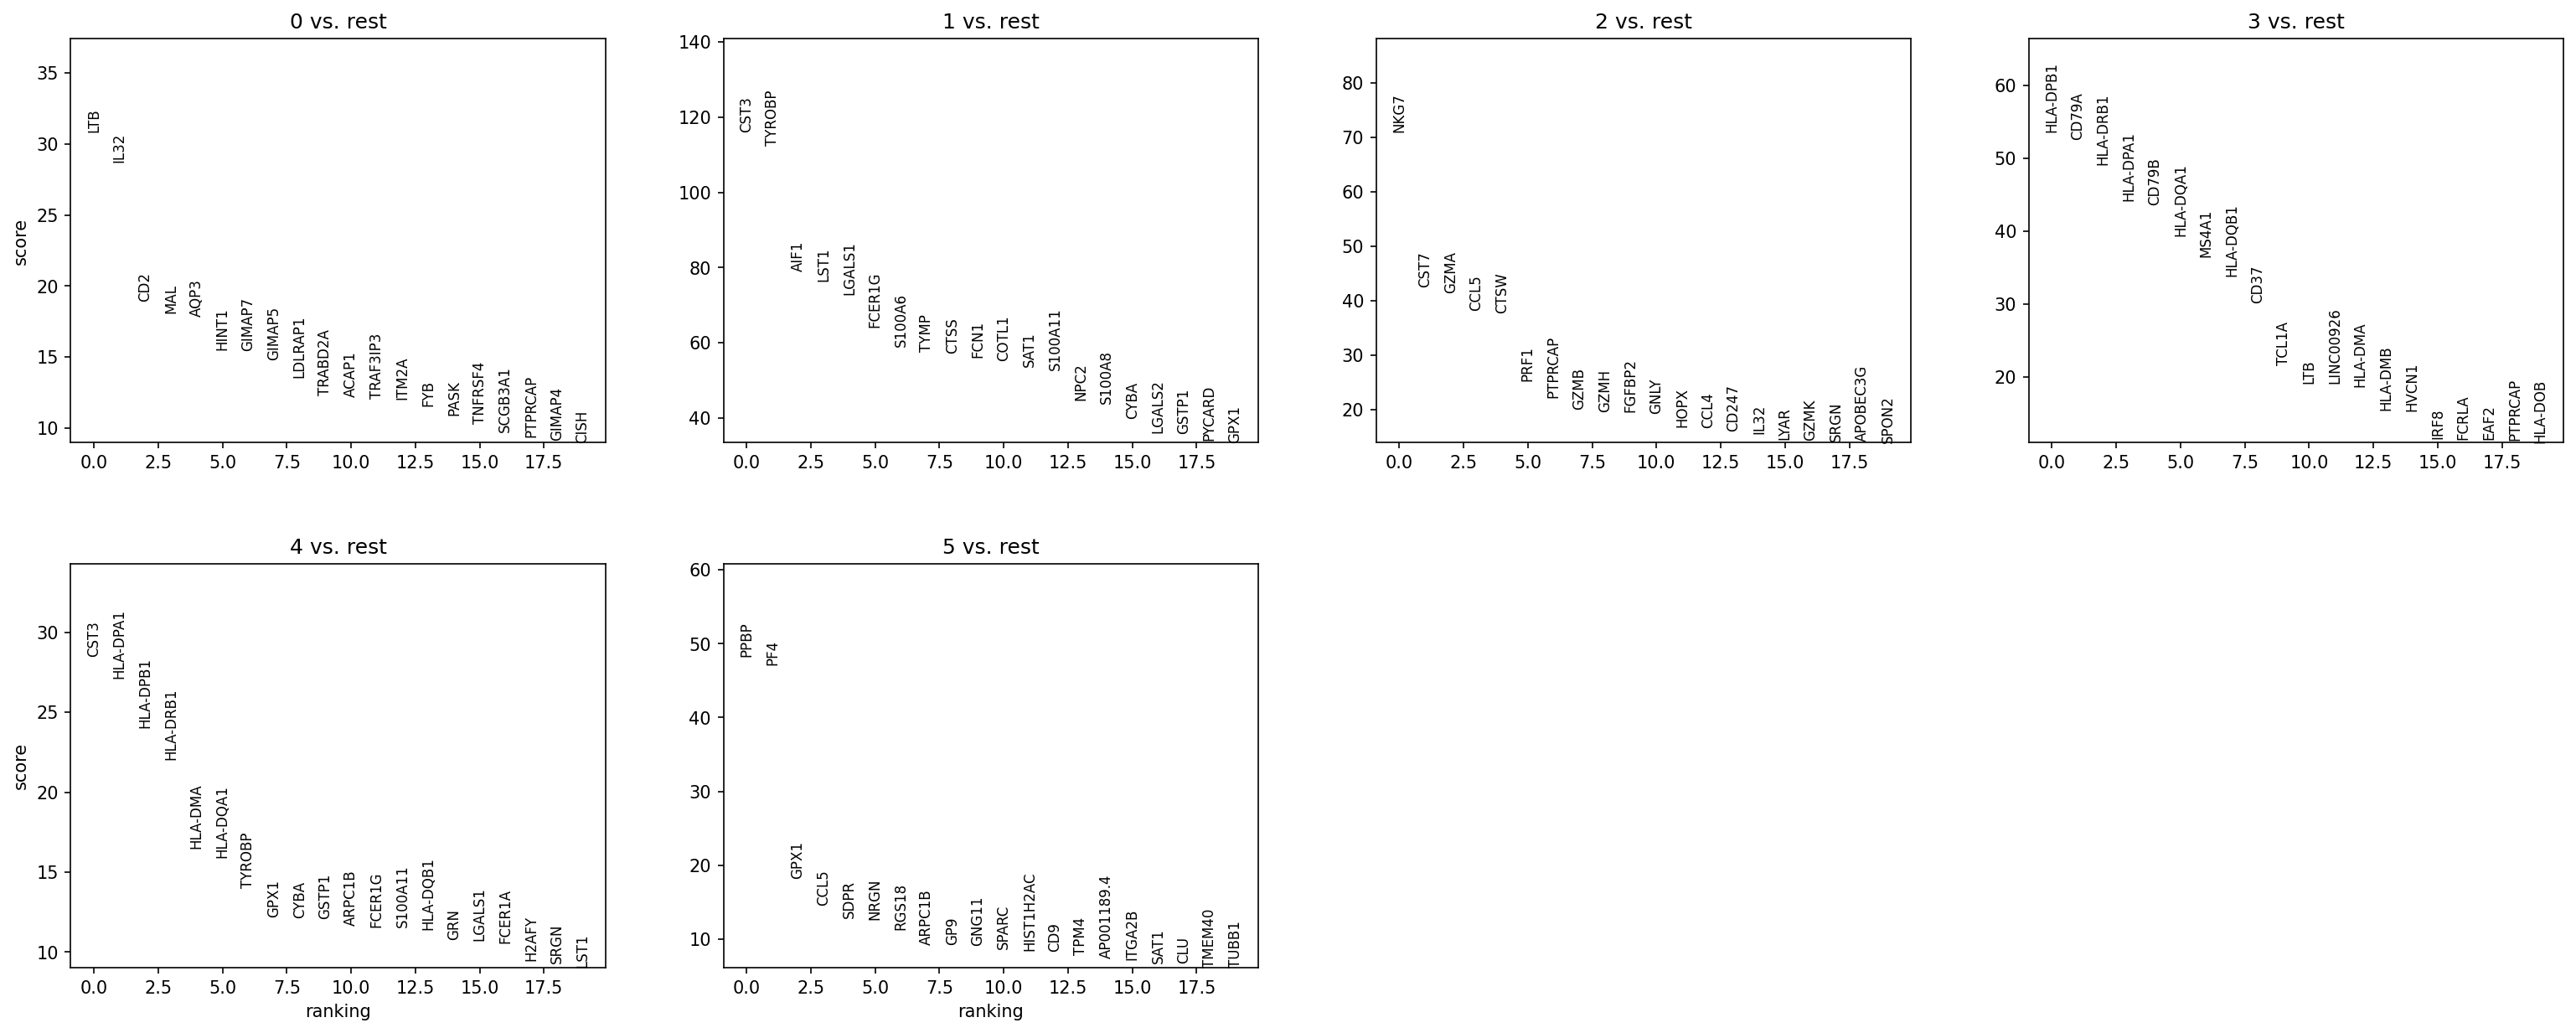

In [6]:
# Rank marker genes per cluster using t-test
sc.tl.rank_genes_groups(adata, groupby="leiden", method="t-test")

# Plot the top 20 marker genes per cluster
sc.pl.rank_genes_groups(
    adata,
    n_genes=20,
    sharey=False,
    show=False  # Do not display inline
)

# Save to file
plt.savefig("../outputs/top20_marker_genes.png", bbox_inches="tight", dpi=150)
plt.close()

from IPython.display import Image
Image(filename="../outputs/top20_marker_genes.png")


In [ ]:
# Set of known marker genes to visualize
marker_genes = ["NKG7", "GZMB", "CST3", "PPBP", "MS4A1", "CD79A", "FCGR3A"]

# Create and save one UMAP plot per gene
for gene in marker_genes:
    if gene in adata.var_names:
        sc.pl.umap(
            adata,
            color=gene,
            show=False
        )
        plt.savefig(f"../outputs/umap_expr_{gene}.png", bbox_inches="tight", dpi=150)
        plt.close()
    else:
        print(f"⚠️ Gene {gene} not found in dataset.")

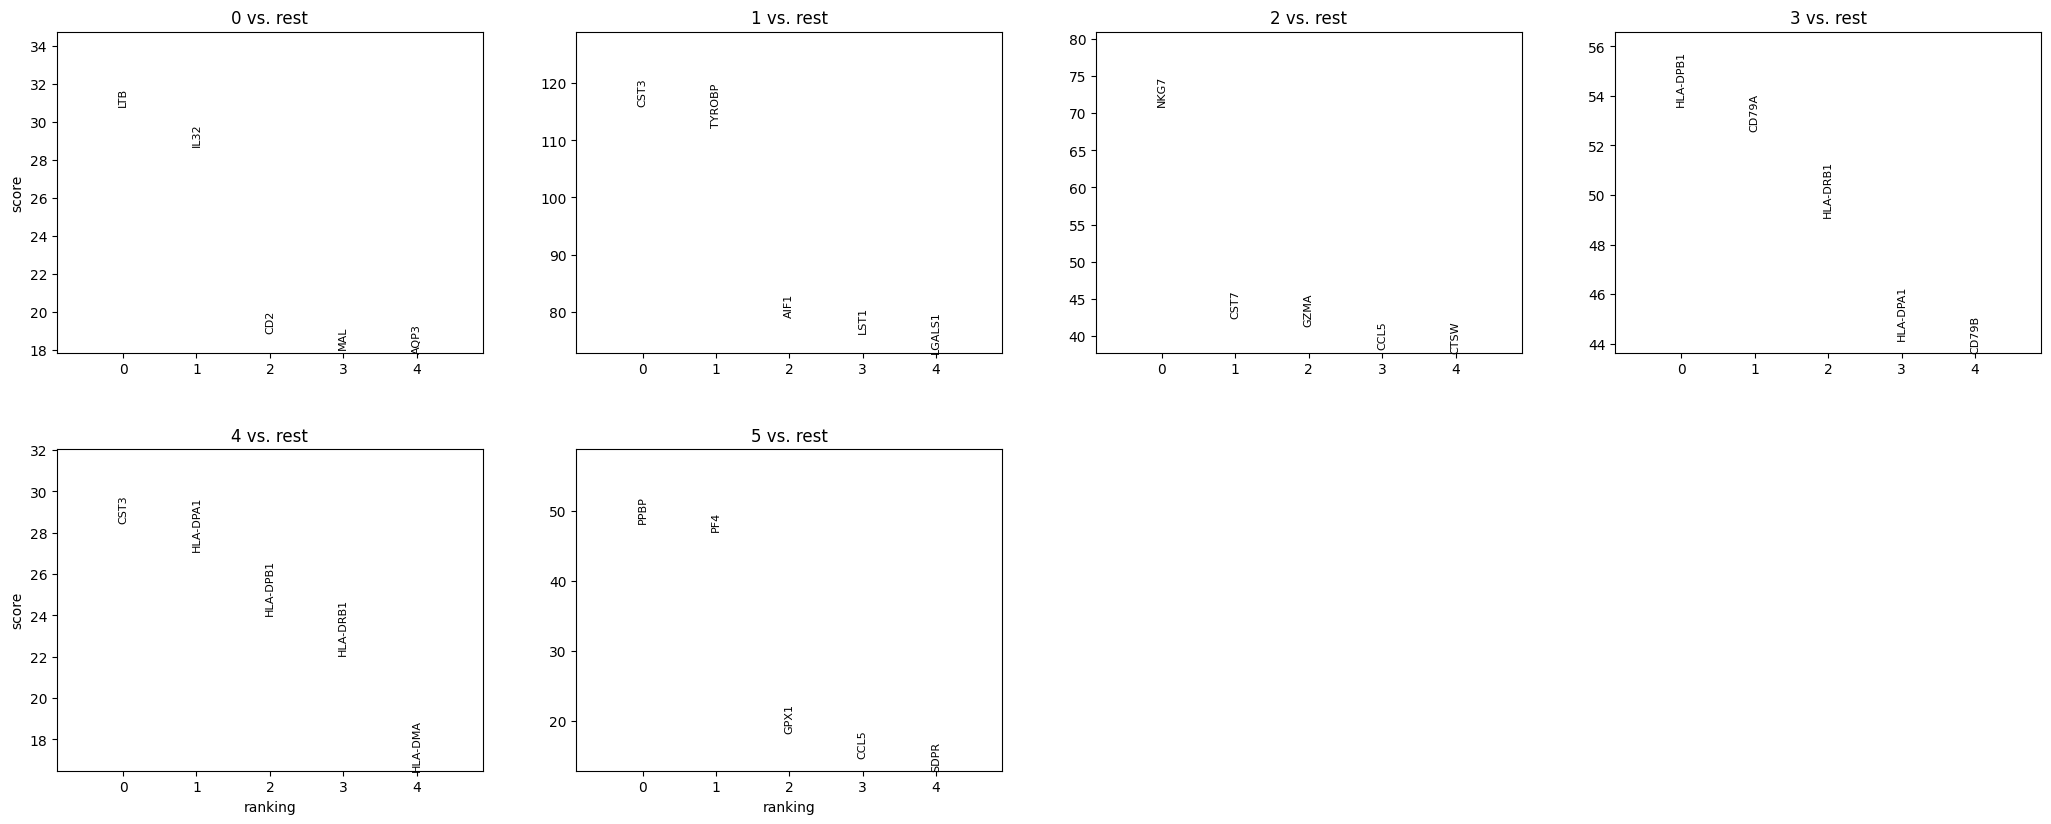

In [8]:
sc.pl.rank_genes_groups(
    adata,
    n_genes=5,
    sharey=False
)


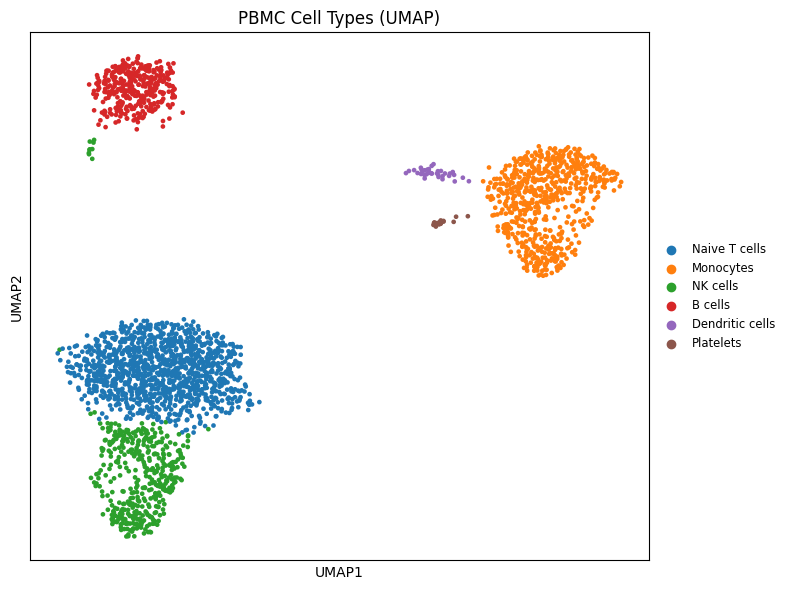

In [9]:
import matplotlib.pyplot as plt

# 1. Manual annotation based on Leiden cluster IDs
cluster2annotation = {
    '0': 'Naive T cells',
    '1': 'Monocytes',
    '2': 'NK cells',
    '3': 'B cells',
    '4': 'Dendritic cells',
    '5': 'Platelets'
}

# 2. Add a new column to .obs for annotation
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster2annotation)

# 3. Plot UMAP with cleaner external legend
fig, ax = plt.subplots(figsize=(8, 6))
sc.pl.umap(
    adata, 
    color='cell_type', 
    ax=ax,
    show=False,
    legend_loc='right margin',
    legend_fontsize='small',
    title='PBMC Cell Types (UMAP)'
)

# 4. Save to outputs folder
plt.tight_layout()
plt.savefig("../outputs/umap_celltype_annotation_clean.png", dpi=300, bbox_inches='tight')
plt.show()
